## Install requirements

https://docs.dwavesys.com/docs/latest/doc_getting_started.html

## Run this block of codes to load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dwave.system import LeapHybridCQMSampler
import dimod
from collections import defaultdict
from itertools import product

## Job shop problem definition

In [19]:
# # Define constants
# num_jobs = 4
# num_machines = 4 + 1
# num_time_slots = 8

# J = range(1, num_jobs+1)  # jobs
# M = range(1, num_machines + 1)   # machines
# T = range(1, num_time_slots+1)  # time slots

# # Define constants
# w = {1: 10, 2: 30, 3: 20, 4: 10}  # j: tardiness weights
# E = {(1, 1): 1, (1, 2): 1, (1, 3): 2, (1, 4): 2, (1, 5): 0,
#      (2, 1): 2, (2, 2): 0, (2, 3): 1, (2, 4): 0, (2, 5): 0,
#      (3, 1): 1, (3, 2): 1, (3, 3): 0, (3, 4): 1, (3, 5): 0,
#      (4, 1): 0, (4, 2): 2, (4, 3): 0, (4, 4): 0, (4, 5): 0}  # (j, m): earliness weights

# p = {(1, 1): 2, (1, 2): 1, (1, 3): 2, (1, 4): 1, (1, 5): 0,
#      (2, 1): 2, (2, 2): 1, (2, 3): 2, (2, 4): 1, (2, 5): 0,
#      (3, 1): 2, (3, 2): 1, (3, 3): 2, (3, 4): 1, (3, 5): 0,
#      (4, 1): 2, (4, 2): 1, (4, 3): 2, (4, 4): 1, (4, 5): 0}  # (j, m): processing times

# d = {1: 4, 2: 4, 3: 4, 4: 4}  # j: due dates
# mp = {(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3, (1, 5): 4,
#      (2, 1): 4, (2, 2): 1, (2, 3): 2, (2, 4): 0, (2, 5): 3,
#      (3, 1): 4, (3, 2): 1, (3, 3): 0, (3, 4): 3, (3, 5): 2,
#      (4, 1): 4, (4, 2): 0, (4, 3): 2, (4, 4): 3, (4, 5): 1}  # (j, m): previous machine

# Define constants
num_jobs = 2
num_machines = 3 + 1
num_time_slots = 14

J = range(1, num_jobs+1)  # jobs
M = range(1, num_machines + 1)   # machines
T = range(1, num_time_slots+1)  # time slots

# Define constants
w = {1: 5, 2: 2}  # j: tardiness weights
E = {(1, 1): 1, (1, 2): 0.5, (1, 3): 1.5, (1, 4): 0,
     (2, 1): 1, (2, 2): 0.9, (2, 3): 0.6, (2, 4): 0}  # (j, m): earliness weights

p = {(1, 1): 4, (1, 2): 4, (1, 3): 4, (1, 4): 0,
     (2, 1): 3, (2, 2): 5, (2, 3): 2, (2, 4): 0}  # (j, m): processing times

d = {1: 12, 2: 14}  # j: due dates
mp = {(1, 1): 0, (1, 2): 1, (1, 3): 2, (1, 4): 3,
     (2, 1): 3, (2, 2): 1, (2, 3): 0, (2, 4): 2}  # (j, m): previous machine

In [20]:
P = {}
Pp = {}
for j in J:
    P[(j, num_machines)] = 0
    Pp[(j, num_machines)] = 0
    m = num_machines
    while (j, m) in mp:
            mpp = mp[(j, m)]
            if mpp != 0:
                P[(j, mpp)] = P[(j, m)] + p[(j,mpp)]
                Pp[(j, mpp)] = Pp[(j, m)] + p[(j,m)]
            m = mpp

sumE = {i: sum(value for key, value in E.items() if key[0] == i) for i in set(key[0] for key in E)}

sum_E_per_j = {j: sum(E[j, m] for m in range(1, num_machines + 1)) for j in range(1, num_jobs + 1)}

h = [1, 200, 200, 200, 200, 0]

## Create Variables for the problem

In [21]:
# Generate all combinations of variables
variables = list(product(range(1, num_jobs + 1), range(1, num_machines + 1), range(1, num_time_slots + 1)))

# Initialize an empty QUBO dictionary
Q = {}

# Populate QUBO dictionary with random coefficients
for (j1, m1, t1) in variables:
    for (j2, m2, t2) in variables:
        Q[((j1,m1,t1), (j2,m2,t2))] = 0
Q[(), ()] = 0

len(Q)

12545

## Objective function: W E/T Cost

In [9]:
constant_shift = 0

# Function to add/update QUBO coefficients
def add_to_qubo(Q, var1, var2, value):
    if (var1, var2) in Q:
        Q[(var1, var2)] += value
    elif (var2, var1) in Q:
        Q[(var2, var1)] += value
    else:
        Q[(var1, var2)] = value

add_to_qubo(Q, (), (), (constant_shift ** 2)*h[5])

summ = sum(-d[j] * w[j] for j in J)
coeff = summ**2
add_to_qubo(Q, (), (), coeff*h[5])

# Construct the QUBO
for j in J:
    coeff = -(-d[j] * w[j])*2*constant_shift
    add_to_qubo(Q, (), (), coeff*h[5])
    for m in M:
        for t in T:
            coeff = (E[(j, m)] * (t + Pp[(j, m)]))*2*constant_shift
            add_to_qubo(Q, (j,m,t), (j,m,t), coeff*h[5])
            
            summ = sum(-d[j] * w[j] for j in J)
            coeff = -(E[(j, m)] * (t + Pp[(j, m)]))*2*summ
            add_to_qubo(Q, (j,m,t), (j,m,t), coeff*h[5])

            for jp in J:
                 for mpp in M:
                     for tp in T:
                        coeff = (E[(j, m)] *E[(jp, mpp)] * t * Pp[(jp, mpp)])*2
                        add_to_qubo(Q, (j,m,t), (jp,mpp,tp), coeff*h[5])

                        coeff = (E[(j, m)] * (t))*(E[(jp, mpp)] * (tp))
                        add_to_qubo(Q, (j,m,t), (jp,mpp,tp), coeff*h[5])
                         
                        coeff = (E[(j, m)] * Pp[(j, m)])*(E[(jp, mpp)] * Pp[(jp, mpp)])
                        add_to_qubo(Q, (j,m,t), (jp,mpp,tp), coeff*h[5])
            
    for t in range(d[j], num_time_slots + 1):
        coeff = -(t*(w[j]+sum_E_per_j[j]))*2*constant_shift
        add_to_qubo(Q, (j,num_machines, t), (j,num_machines, t), coeff*h[5])

        summ = sum(-d[j] * w[j] for j in J)
        coeff = (t*(w[j]+sum_E_per_j[j]))*2*summ
        add_to_qubo(Q, (j,num_machines, t), (j,num_machines, t), coeff*h[5])
                
        for jp in J:
             for mpp in M:
                 for tp in T:
                    coeff = -(E[(jp, mpp)] *tp * t * w[j])*2
                    add_to_qubo(Q, (j,num_machines,t), (jp,mpp,tp), coeff*h[5])

                    coeff = -(E[(jp, mpp)] *Pp[(jp, mpp)] * t * w[j])*2
                    add_to_qubo(Q, (j,num_machines,t), (jp,mpp,tp), coeff*h[5])

                    coeff = -(E[(jp, mpp)] *tp * t * sum_E_per_j[j])*2
                    add_to_qubo(Q, (j,num_machines,t), (jp,mpp,tp), coeff*h[5])

                    coeff = -(E[(jp, mpp)] *Pp[(jp, mpp)] * t * sum_E_per_j[j])*2
                    add_to_qubo(Q, (j,num_machines,t), (jp,mpp,tp), coeff*h[5])

        for jp in J:
            for tp in T:
                coeff = (tp * w[jp]* t * sum_E_per_j[j])*2
                add_to_qubo(Q, (j,num_machines,t), (jp,num_machines,tp), coeff*h[5])

                coeff = (t * w[j])*(tp * w[jp])
                add_to_qubo(Q, (j,num_machines,t), (jp,num_machines,tp), coeff*h[5])
        
                coeff = (t *sum_E_per_j[j])*(tp *sum_E_per_j[jp])
                add_to_qubo(Q, (j,m,t), (jp,num_machines,tp), coeff*h[5])

In [22]:
# Define the variables and the objective function
constant_value = 0
for j in J:
    constant_value = - d[j]*w[j]*h[0]
    Q[(), ()] += constant_value
    for t in range(d[j], num_time_slots + 1):
        var_name = (j, num_machines, t)
        # Linear term (w[j] + sumE[j]) * t * x_jmt
        Q[var_name, var_name] += ((w[j] + sumE[j]) * t)*h[0]
        
    for tp in range(1, num_time_slots + 1):
        for m in range(1, num_machines):
            var_name = (j, m, tp)
            # Quadratic term -E[j,m] * (tp + Pp[j,m]) * x_jmt
            Q[var_name, var_name] += (-E[j, m] * (tp + Pp[j, m]))*h[0]

## Constraint 1: No − overlap

In [23]:
for m in range(1, num_machines):
    for j in J:
        for t in T:
            for jp in J:
                if j != jp:
                    for tp in range(t, t + p[jp, m] - 1 + 1):
                        if tp <= num_time_slots:
                            var1 = (j, m, t)
                            var2 = (jp, m, tp)
                            Q[(var1, var2)] += 1*h[1]

## Constraint 2: Precedence

In [24]:
for j in J:
    for m in range(1, num_machines):
        if (j, m) in mp:
            for t in T:
                for tp in range(1, t + p[j, m] - 1 + 1):
                    if tp <= num_time_slots:
                        if mp[j, m] != 0:
                            var1 = (j, mp[j, m], t)
                            var2 = (j, m, tp)
                            Q[(var1, var2)] += 1*h[2]

for j in J:
    m = num_machines
    for t in range(d[j], num_time_slots+1):
        for tp in range(1, t- 1 + 1):
            if mp[j, m] != 0:
                var1 = (j, mp[j, m], t)
                var2 = (j, m, tp)
                Q[(var1, var2)] += 1*h[2]

## Constraint 3: Operation once

In [25]:
for j in J:
    for m in range(1, num_machines):
        if p[j, m] > 0:
            constant_value = + h[3]
            Q[(), ()] += constant_value
            # Add quadratic terms
            for t in range(p[j, m], num_time_slots+1):
                var1 = (j, m, t)
                Q[(var1, var1)] -= 1*h[3]  # y_{j,m,t}^2
                for tp in range(p[j, m], num_time_slots+1):
                    if t != tp:
                        var2 = (j, m, tp)
                        Q[(var1, var2)] += 2*h[3]  # y_{j,m,t} y_{j,m,tp}
            for t in range(1, p[j, m]):
                for tp in range(1, p[j, m]):
                    var1 = (j, m, t)
                    var2 = (j, m, tp)
                    Q[(var1, var2)] += 1*h[3]  # y_{j,m,t} y_{j,m,tp}

## Constraint 4: Tardy − once

In [26]:
for j in J:
    constant_value = + h[4]
    Q[(), ()] += constant_value
    tmp = 0
    for t in range(d[j], num_time_slots + 1):
        var = (j, num_machines, t)
        tmp += 1
        Q[(var, var)] += 1*h[4]
        for tp in range(d[j], num_time_slots + 1):
            if tp != t:
                Q[(var, (j, num_machines, tp))] += 2*h[4]
        Q[(var, var)] -= 2*h[4]

In [27]:
# Convert QUBO dictionary to a format compatible with D-Wave
qubo = dict(Q)

# Print terms with coefficients greater than zero
for key, value in qubo.items():
    if value != 0:
        print(f"QUBO term {key}: coefficient = {value}")

QUBO term ((1, 1, 1), (1, 1, 1)): coefficient = 191
QUBO term ((1, 1, 1), (1, 1, 2)): coefficient = 200
QUBO term ((1, 1, 1), (1, 1, 3)): coefficient = 200
QUBO term ((1, 1, 1), (1, 2, 1)): coefficient = 200
QUBO term ((1, 1, 1), (1, 2, 2)): coefficient = 200
QUBO term ((1, 1, 1), (1, 2, 3)): coefficient = 200
QUBO term ((1, 1, 1), (1, 2, 4)): coefficient = 200
QUBO term ((1, 1, 1), (2, 1, 1)): coefficient = 200
QUBO term ((1, 1, 1), (2, 1, 2)): coefficient = 200
QUBO term ((1, 1, 1), (2, 1, 3)): coefficient = 200
QUBO term ((1, 1, 2), (1, 1, 1)): coefficient = 200
QUBO term ((1, 1, 2), (1, 1, 2)): coefficient = 190
QUBO term ((1, 1, 2), (1, 1, 3)): coefficient = 200
QUBO term ((1, 1, 2), (1, 2, 1)): coefficient = 200
QUBO term ((1, 1, 2), (1, 2, 2)): coefficient = 200
QUBO term ((1, 1, 2), (1, 2, 3)): coefficient = 200
QUBO term ((1, 1, 2), (1, 2, 4)): coefficient = 200
QUBO term ((1, 1, 2), (1, 2, 5)): coefficient = 200
QUBO term ((1, 1, 2), (2, 1, 2)): coefficient = 200
QUBO term ((

## Create the QUBO model and solve it using SimulatedAnnealingSampler

In [30]:
mylist = []
mytasktimes = []
for i in range(1):
    qubo = dict(Q)

    bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
    
    # Solve the problem using simulated annealing
    sampler = dimod.SimulatedAnnealingSampler()
    num_reads = 100
    # Create a linear beta schedule with the desired number of sweeps
    beta_range = [0.1, 10.0]

    response = sampler.sample(bqm, num_reads=num_reads, beta_range=beta_range)
    
    # Extract the minimum energy sample(s)
    min_energy = float('inf')
    min_sample = None
    
    for sample, energy in response.data(['sample', 'energy']):
        if energy < min_energy:
            min_energy = energy
            min_sample = sample
    
    mylist.append(min_energy + Q[(), ()])
    best_solution = min_sample

    # Print the minimized objective function value and corresponding sample
    print("\nMinimized Objective Function Value:", min_energy + Q[(), ()])
    print("Corresponding Sample:", min_sample)
    
    print("\nVariables with value 1 in the minimized sample:")
    for key, value in min_sample.items():
        if value == 1:
            print(key)


Minimized Objective Function Value: 1008.0
Corresponding Sample: {(): 0, (1, 1, 1): 0, (1, 1, 2): 0, (1, 1, 3): 0, (1, 1, 4): 0, (1, 1, 5): 0, (1, 1, 6): 0, (1, 1, 7): 0, (1, 1, 8): 0, (1, 1, 9): 1, (1, 1, 10): 0, (1, 1, 11): 0, (1, 1, 12): 0, (1, 1, 13): 0, (1, 1, 14): 0, (1, 1, 15): 0, (1, 1, 16): 0, (1, 1, 17): 0, (1, 1, 18): 0, (1, 2, 1): 0, (1, 2, 2): 0, (1, 2, 3): 0, (1, 2, 4): 0, (1, 2, 5): 0, (1, 2, 6): 0, (1, 2, 7): 0, (1, 2, 8): 0, (1, 2, 9): 0, (1, 2, 10): 0, (1, 2, 11): 0, (1, 2, 12): 0, (1, 2, 13): 0, (1, 2, 14): 0, (1, 2, 15): 1, (1, 2, 16): 0, (1, 2, 17): 0, (1, 2, 18): 0, (1, 3, 1): 0, (1, 3, 2): 0, (1, 3, 3): 0, (1, 3, 4): 0, (1, 3, 5): 0, (1, 3, 6): 0, (1, 3, 7): 0, (1, 3, 8): 0, (1, 3, 9): 0, (1, 3, 10): 1, (1, 3, 11): 0, (1, 3, 12): 0, (1, 3, 13): 0, (1, 3, 14): 0, (1, 3, 15): 0, (1, 3, 16): 0, (1, 3, 17): 0, (1, 3, 18): 0, (1, 4, 1): 1, (1, 4, 2): 0, (1, 4, 3): 1, (1, 4, 4): 1, (1, 4, 5): 0, (1, 4, 6): 1, (1, 4, 7): 1, (1, 4, 8): 0, (1, 4, 9): 0, (1, 4, 10): 0, (1

## Create the QUBO model and solve it using DWaveSampler

In [28]:
# Convert QUBO dictionary to a format compatible with D-Wave
mylist = []
mytasktimes = []
for i in range(1):
    qubo = dict(Q)
    
    # Use D-Wave sampler to solve the QUBO
    sampler = EmbeddingComposite(DWaveSampler())
    # sampler = LeapHybridSampler(solver={'category': 'hybrid'})
    response = sampler.sample_qubo(qubo, num_reads=1000) #num_reads=100
    
    # Print the results
    print("Best solution: ", response.first.sample)
    print("Energy: ", response.first.energy + Q[(), ()])
    mylist.append(response.first.energy + Q[(), ()])
    best_solution = response.first.sample
    # if response.first.energy + Q[(), ()] <= 0:
    #     print("Variables set to 1 in the best solution:")
    #     for variable, value in best_solution.items():
    #         if value == 1:
    #             print(variable)
    #             mytasktimes.append(variable)
    #     break

Best solution:  {(): 0, (1, 1, 1): 0, (1, 1, 2): 0, (1, 1, 3): 0, (1, 1, 4): 0, (1, 1, 5): 1, (1, 1, 6): 0, (1, 1, 7): 0, (1, 1, 8): 0, (1, 1, 9): 0, (1, 1, 10): 0, (1, 1, 11): 0, (1, 1, 12): 0, (1, 1, 13): 0, (1, 1, 14): 0, (1, 2, 1): 0, (1, 2, 2): 0, (1, 2, 3): 0, (1, 2, 4): 1, (1, 2, 5): 0, (1, 2, 6): 0, (1, 2, 7): 0, (1, 2, 8): 0, (1, 2, 9): 0, (1, 2, 10): 0, (1, 2, 11): 0, (1, 2, 12): 0, (1, 2, 13): 0, (1, 2, 14): 0, (1, 3, 1): 0, (1, 3, 2): 0, (1, 3, 3): 0, (1, 3, 4): 0, (1, 3, 5): 0, (1, 3, 6): 0, (1, 3, 7): 0, (1, 3, 8): 1, (1, 3, 9): 0, (1, 3, 10): 0, (1, 3, 11): 0, (1, 3, 12): 0, (1, 3, 13): 0, (1, 3, 14): 0, (1, 4, 1): 1, (1, 4, 2): 1, (1, 4, 3): 1, (1, 4, 4): 0, (1, 4, 5): 0, (1, 4, 6): 0, (1, 4, 7): 0, (1, 4, 8): 0, (1, 4, 9): 0, (1, 4, 10): 0, (1, 4, 11): 0, (1, 4, 12): 0, (1, 4, 13): 1, (1, 4, 14): 0, (2, 1, 1): 0, (2, 1, 2): 0, (2, 1, 3): 0, (2, 1, 4): 0, (2, 1, 5): 0, (2, 1, 6): 0, (2, 1, 7): 0, (2, 1, 8): 0, (2, 1, 9): 0, (2, 1, 10): 0, (2, 1, 11): 0, (2, 1, 12): 0, (

In [179]:
print("Variables set to 1 in the best solution:")
for variable, value in best_solution.items():
    if value == 1:
        print(variable)
        mytasktimes.append(variable)

Variables set to 1 in the best solution:
(1, 1, 4)
(1, 2, 8)
(1, 3, 13)
(1, 4, 13)
(2, 1, 8)
(2, 2, 13)
(2, 3, 4)
(2, 4, 1)
(2, 4, 5)
(2, 4, 6)
(2, 4, 10)
(2, 4, 14)


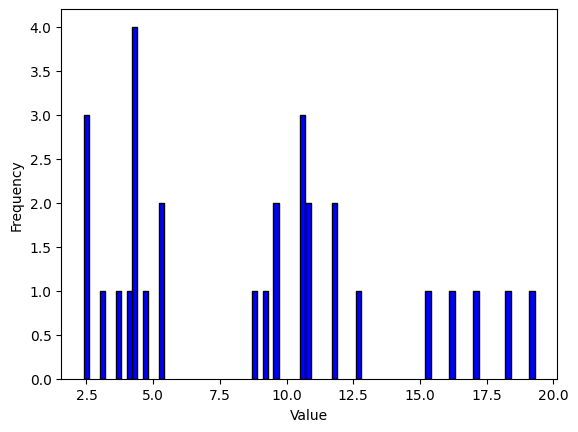

30

In [180]:
import matplotlib.pyplot as plt
from collections import Counter

count = Counter(mylist)

# Extract the unique numbers and their counts
unique_numbers = list(count.keys())
frequencies = list(count.values())

# Filter values less than 1000
filtered_numbers = [num for num in unique_numbers if num < 500]
filtered_frequencies = [frequencies[i] for i, num in enumerate(unique_numbers) if num < 500]

# Create a bar plot with thicker bars
bar_width = 0.2  # Adjust this value to change the bar width
plt.bar(filtered_numbers, filtered_frequencies, width=bar_width, color='blue', edgecolor='black')

# Add titles and labels
# plt.title('Frequency of Each Unique Objective Function Value')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.savefig('frequency_plot.png')
# Show the plot
plt.show()

len(mylist)

In [78]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the finish times as a list of triples (job, machine, finish_time)
finish_times = mytasktimes
# finish_times.append((1,1,0))
# finish_times.append((1,4,0))
# finish_times.append((3,1,0))
# finish_times.append((2,3,0))
# finish_times.append((4,3,0))
# finish_times.append((4,4,0))
print(finish_times)
# Define the process times for each job and machine
process_times = p

# Extract unique jobs and machines
jobs = set(job for job, machine, finish in finish_times)
machines = set(machine for job, machine, finish in finish_times)

# Calculate start times from finish times and process times
start_times = {}
for job, machine, finish in finish_times:
    start_times[(job, machine)] = finish - process_times[(job, machine)]

# Prepare schedule data for plotting
schedule = {}
for job in jobs:
    schedule[f'Job {job}'] = {}
    for machine in machines:
        schedule[f'Job {job}'][f'Machine {machine}'] = (start_times[(job, machine)], 
                                                        next(finish for j, m, finish in finish_times if j == job and m == machine))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the jobs
colors = {
    'Job 1': 'skyblue',
    'Job 2': 'lightgreen',
    # 'Job 3': 'lightcoral',
    # 'Job 4': 'lightgoldenrodyellow'
}  # Extend as needed for more jobs

# Plot each job on each machine
for job, machines in schedule.items():
    for i, (machine, (start, end)) in enumerate(machines.items()):
        if i < len(machines) - 1:  # Check
            ax.barh(machine, end - start, left=start, color=colors[job], edgecolor='black')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Machines')
# ax.set_title('Gantt Chart for Scheduling of Jobs on Machines')

# Add legend
patches = [mpatches.Patch(color=colors[job], label=job) for job in colors]
ax.legend(handles=patches, loc='upper right')

plt.savefig('Gantt Chart.png')
# Show the plot
plt.show()


[(1, 1, 3), (1, 2, 5), (1, 3, 9), (2, 1, 5), (2, 2, 8), (2, 3, 3), (2, 4, 2), (2, 4, 4), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 9)]


KeyError: (1, 4)

In [53]:
sample = {(): 1, (1, 1, 1): 0, (1, 1, 2): 1, (1, 1, 3): 0, (1, 1, 4): 0, (1, 1, 5): 0, (1, 1, 6): 0, (1, 1, 7): 0, (1, 1, 8): 0, (1, 1, 9): 0, (1, 2, 1): 0, (1, 2, 2): 0, (1, 2, 3): 0, (1, 2, 4): 1, (1, 2, 5): 0, (1, 2, 6): 0, (1, 2, 7): 0, (1, 2, 8): 0, (1, 2, 9): 0, (1, 3, 1): 0, (1, 3, 2): 0, (1, 3, 3): 0, (1, 3, 4): 0, (1, 3, 5): 0, (1, 3, 6): 1, (1, 3, 7): 0, (1, 3, 8): 0, (1, 3, 9): 0, (1, 4, 1): 0, (1, 4, 2): 0, (1, 4, 3): 0, (1, 4, 4): 0, (1, 4, 5): 0, (1, 4, 6): 1, (1, 4, 7): 0, (1, 4, 8): 0, (1, 4, 9): 0, (2, 1, 1): 0, (2, 1, 2): 0, (2, 1, 3): 0, (2, 1, 4): 0, (2, 1, 5): 1, (2, 1, 6): 0, (2, 1, 7): 0, (2, 1, 8): 0, (2, 1, 9): 0, (2, 2, 1): 0, (2, 2, 2): 0, (2, 2, 3): 0, (2, 2, 4): 0, (2, 2, 5): 0, (2, 2, 6): 0, (2, 2, 7): 0, (2, 2, 8): 1, (2, 2, 9): 0, (2, 3, 1): 0, (2, 3, 2): 0, (2, 3, 3): 1, (2, 3, 4): 0, (2, 3, 5): 0, (2, 3, 6): 0, (2, 3, 7): 0, (2, 3, 8): 0, (2, 3, 9): 0, (2, 4, 1): 0, (2, 4, 2): 1, (2, 4, 3): 0, (2, 4, 4): 1, (2, 4, 5): 0, (2, 4, 6): 0, (2, 4, 7): 0, (2, 4, 8): 0, (2, 4, 9): 1}
energy = 0
mytasktimes = []
print("Variables set to 1 in the best solution:")
for variable, value in sample.items():
    if value == 1:
        print(variable)
        mytasktimes.append(variable)

# Calculate the energy
for (i, j), coeff in qubo.items():
    x_i = sample.get(i, 0)
    x_j = sample.get(j, 0)
    energy += coeff * x_i * x_j

print("Energy of the given sample:", energy)


Variables set to 1 in the best solution:
()
(1, 1, 2)
(1, 2, 4)
(1, 3, 6)
(1, 4, 6)
(2, 1, 5)
(2, 2, 8)
(2, 3, 3)
(2, 4, 2)
(2, 4, 4)
(2, 4, 9)
Energy of the given sample: 2.5
